# Using Snorkel to Extract Educational Background of Artists

**Note**: 
- Much content of this notebook was borrowed from Snorkel Introduction Tutorial
- You are supposed to write your code or modify our code in any cell starting with `# ** STUDENT CODE`.

State-of-the-art extraction techniques require massive labeled training set but it is costly to obtain. To overcome this problem, Snorkel helps rapidly create training sets using the new data programming paradigm. To start, developers focus on writing a set of labeling functions, which are just scripts that programmatically label data. The resulting labels are noisy, but Snorkel uses a generative model to learn how to use those labeling functions to label more data. The new labeled data now can be used to train high-quality end models.

In summary, in this task, you will first manually label 50 documents and use these labeled data as a development set to create your own labeling functions. Then, you will train a generative model to label 800 documents in training set. Finally, you will train Bi-LSTM to extract final extraction.

**Preprocessing and creating dev set**

Before you proceed with task 2.1, we need to preprocess our documents using `Snorkel` utilities, parsing them into a simple hierarchy of component parts of our input data, which we refer as _contexts_. We'll also create _candidates_ out of these contexts, which are the objects we want to classify, in this case, possible mentions of schools. Finally, we'll load some gold labels for evaluation.

All of this preprocessed input data is saved to a database. In Snorkel, if no database is specified, then a SQLite database at `./snorkel.db` is created by default -- so no setup is needed here!

In [1]:
# ** STUDENT CODE

import numpy as np, os
from pathlib import Path

from snorkel import SnorkelSession
from snorkel.parser import TSVDocPreprocessor, CorpusParser
from snorkel.parser.spacy_parser import Spacy
from snorkel.models import Document, Sentence, candidate_subclass
from snorkel.viewer import SentenceNgramViewer
from snorkel.annotations import LabelAnnotator, load_gold_labels

from utils import reload_external_labels, save_gold_labels, save_predicted_relations, save_gold_relations, get_dev_doc_ids, get_test_doc_ids, get_gold_labels, number_of_people

# TODO: Set location where you store your homework 2
if 'HW_DIR' not in os.environ:
    HW_DIR = Path("/Users/muxin/Desktop/KnowledgeGraph/KnowledgeGraph/hw2/Homework 2/")
else:
    HW_DIR = Path(os.environ['HW_DIR'])
    assert HW_DIR.exists()

**Initializing a `SnorkelSession`**

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

session = SnorkelSession()

**Loading the Corpus**

Next, we load and pre-process the corpus of documents.

In [3]:
doc_preprocessor = TSVDocPreprocessor(HW_DIR / 'artists_bio.tsv')

In [4]:
"HW_DIR" in os.environ

False

**Running a `CorpusParser`**

We'll use [Spacy](https://spacy.io/), an NLP preprocessing tool, to split our documents into sentences and tokens, and provide named entity annotations.

In [5]:
corpus_parser = CorpusParser(parser=Spacy())
%time corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 25.8 s, sys: 400 ms, total: 26.2 s
Wall time: 26.2 s


We can then use simple database queries (written in the syntax of [SQLAlchemy](http://www.sqlalchemy.org/), which Snorkel uses) to check how many documents and sentences were parsed:

In [6]:
print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

Documents: 1105
Sentences: 10569


**Generating Candidates**

The next step is to extract _candidates_ from our corpus. A `Candidate` in Snorkel is an object for which we want to make a prediction. In this case, the candidates are pairs of person and organization mentioned in sentences.

The [Spacy](https://spacy.io/) parser we used performs _named entity recognition_ for us. Next, we'll split up the documents into train, development, and test splits; and collect the associated sentences.

In [7]:
Education = candidate_subclass('Education', ['person', 'organization'])

In [8]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import PersonMatcher, OrganizationMatcher

ngrams         = Ngrams(n_max=7)
person_matcher = PersonMatcher(longest_match_only=True)
organization_matcher = OrganizationMatcher(longest_match_only=True)
cand_extractor = CandidateExtractor(Education, [ngrams, ngrams], [person_matcher, organization_matcher])

In [9]:
docs = session.query(Document).order_by(Document.name).all()

dev_docs = get_dev_doc_ids(HW_DIR / "artists.dev.txt")
test_docs = get_test_doc_ids(HW_DIR / "artists.test.txt")

train_sents = set()
dev_sents   = set()
test_sents  = set()

for doc in docs:
    sents = (s for s in doc.sentences if number_of_people(s) <= 5)
    if doc.name in dev_docs:
        dev_sents.update(sents)
    elif doc.name in test_docs:
        test_sents.update(sents)
    else:
        train_sents.update(sents)
        
print("Number of dev sents:", len(dev_sents))
print("Number of train sents:", len(train_sents))
print("Number of test sents:", len(test_sents))

Number of dev sents: 541
Number of train sents: 7025
Number of test sents: 2953


Finally, we'll apply the candidate extractor to the three sets of sentences. The results will be persisted in the database backend.

In [10]:
%%time
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Education).filter(Education.split == i).count())

  0%|          | 18/7025 [00:00<00:39, 179.12it/s]

Clearing existing...
Running UDF...


  4%|▍         | 21/541 [00:00<00:02, 209.43it/s]

Number of candidates: 4415
Clearing existing...
Running UDF...


  1%|          | 23/2953 [00:00<00:12, 226.34it/s]

Number of candidates: 285
Clearing existing...
Running UDF...


100%|██████████| 2953/2953 [00:12<00:00, 232.06it/s]

Number of candidates: 1560
CPU times: user 47.8 s, sys: 501 ms, total: 48.3 s
Wall time: 48.2 s


## Task 2.1. Label 50 documents in development set

In this task, you will use `SentenceNgramViewer` to label each mention. You can click Blue button to mark the candidate as correct, Red button to mark as incorrect. Your labeling result is automatically stored in the database.

In [30]:
gold_labels = get_gold_labels(session)
labeled_sents = {lbl.candidate.person.sentence.id for lbl in gold_labels}
unlabeled = [
    x for x in session.query(Education).filter(Education.split == 1).all() 
    if x.person.sentence.id not in labeled_sents
]
print("Number unlabeled:", len(unlabeled))

Number unlabeled: 0


In [25]:
SentenceNgramViewer(unlabeled, session, annotator_name="gold")

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[201], [149, 150, 222, 223, 244, 245], [125, 211]], [[80], [136], [35, 36, 127, 128…

After you finish labeling, executing the cell below to **save your result** to JSON files. 

In [31]:
save_gold_labels(session, HW_DIR / "gold_labels.dev.json", split=1)
save_gold_relations(session, HW_DIR / "extracted_relation.dev.json", split=1)

## Task 2.2 Define labeling functions (LFs)

In this task, you will define your own LFs, which Snorkel uses to create noise-aware training set. Usually, you will go through a couple of iterations (create LFs, test and refine it) to come up with a good set of LFs. We provide you at the end of Task 2.2 a helper to quickly see what candidates did your model fail to classify. You can refer to Snorkel tutorial or online documentation for more information.

You are free to use write any extra code to create a set of sophisticated LFs. For example, you build a list of universities and check if it matches with your candidate.

In [26]:
dir(Education)

['__argnames__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mapper__',
 '__mapper_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__table__',
 '__table_args__',
 '__tablename__',
 '__weakref__',
 '_decl_class_registry',
 '_sa_class_manager',
 'cardinality',
 'features',
 'get_cids',
 'get_contexts',
 'get_parent',
 'gold_labels',
 'id',
 'labels',
 'metadata',
 'organization',
 'organization_cid',
 'organization_id',
 'person',
 'person_cid',
 'person_id',
 'predictions',
 'split',
 'type',
 'values']

In [62]:
# ** STUDENT CODE 
# TODO: Define your LFs here, below is a very simple LF
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text, 
)
other_relavence = {"teaching", "visiting", "invited"}

possible_name = {"university", "school", "institute"}

possible_degree = {"bachelor", "master", "doctor", "PhD"}



def university_sample(c):
    words = c.organization.get_span().split()
    for word in words:
        if word.lower() in possible_name:
            return 1
    return 0

def degree_sample(c):
    return 1 if len(possible_degree.intersection(get_between_tokens(c))) > 0 else 0


def verb_sample(c):
    return -1 if len(other_relavence.intersection(get_between_tokens(c))) > 0 else 0



In [63]:
# ** STUDENT CODE
# TODO: store all of your labeling functions into LFs

LFs = [university_sample, degree_sample, verb_sample]

**Train generative model**

In [64]:
np.random.seed(1701)

labeler = LabelAnnotator(lfs=LFs)
L_train = labeler.apply(split=0)

  1%|          | 26/4415 [00:00<00:17, 257.77it/s]

Clearing existing...
Running UDF...


100%|██████████| 4415/4415 [00:16<00:00, 275.88it/s]


In [65]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

print("LF weights:", gen_model.weights.lf_accuracy)

Inferred cardinality: 2
LF weights: [ 0.12281399  0.08098221  0.07761514]


We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [66]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

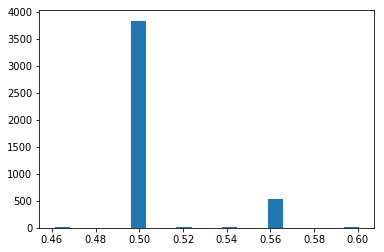

In [67]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

Now that we have learned the generative model, we will measure its performances using the provided test set

In [68]:
# Load testset first
reload_external_labels(session, HW_DIR / "gold_labels.test.json")
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

AnnotatorLabels created: 0
AnnotatorLabels created: 0


In [69]:
L_dev = labeler.apply_existing(split=1)
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

  9%|▉         | 25/285 [00:00<00:01, 240.74it/s]

Clearing existing...
Running UDF...


100%|██████████| 285/285 [00:01<00:00, 247.51it/s]


Scores (Un-adjusted)
Pos. class accuracy: 0.552
Neg. class accuracy: 0.934
Precision            0.485
Recall               0.552
F1                   0.516
----------------------------------------
TP: 16 | FP: 17 | TN: 239 | FN: 13



Get detailed statistics of LFs learned by the model

In [70]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/Users/muxin/miniconda3/envs/snorkel/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
university_sample,0,0.115789,0.0,0.0,16,17,0,0,0.484848,0.567396
degree_sample,1,0.000000,0.0,0.0,0,0,0,0,NaN,0.551524
verb_sample,2,0.010526,0.0,0.0,0,0,0,3,1.000000,0.547491


You might want to look at some examples in one of the error buckets to improve your LFs. For example, below is one of the false negatives that we did not correctly label as true mentions

In [71]:
SentenceNgramViewer(fn, session)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[7], [9], [4]], [[10, 11, 12], [5], [6]], [[0, 1], [3], [8]], [[2]]], html='<head>\…

## Task 2.3. Training an End Extraction Model

In this final task, we'll use the noisy training labels we generated to train our end extraction model. In particular, we will be training a Bi-LSTM.

In [72]:
train_cands = session.query(Education).filter(Education.split == 0).order_by(Education.id).all()
dev_cands   = session.query(Education).filter(Education.split == 1).order_by(Education.id).all()
test_cands  = session.query(Education).filter(Education.split == 2).order_by(Education.id).all()

In [73]:
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

Try tuning the hyper-parameters below to get your best F1 score

In [136]:
# ** STUDENT CODE

from snorkel.learning.pytorch import LSTM

train_kwargs = {
    'lr':            0.1,
    'embedding_dim': 20,
    'hidden_dim':    200,
    'n_epochs':      30,
    'dropout':       0.25,
    'seed':          101
}

lstm = LSTM(n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[LSTM] Training model
[LSTM] n_train=580  #epochs=30  batch size=64


/Users/muxin/miniconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[LSTM] Epoch 1 (1.74s)	Average loss=1.514413	Dev F1=8.16
[LSTM] Epoch 2 (3.77s)	Average loss=0.858210	Dev F1=13.92
[LSTM] Epoch 3 (5.81s)	Average loss=0.820049	Dev F1=13.92
[LSTM] Epoch 4 (7.92s)	Average loss=0.789061	Dev F1=3.92
[LSTM] Epoch 5 (9.99s)	Average loss=0.812852	Dev F1=12.56
[LSTM] Epoch 6 (12.12s)	Average loss=0.779563	Dev F1=14.01
[LSTM] Epoch 7 (14.18s)	Average loss=0.758724	Dev F1=14.63
[LSTM] Epoch 8 (16.26s)	Average loss=0.746075	Dev F1=0.00
[LSTM] Epoch 9 (18.25s)	Average loss=0.735736	Dev F1=18.67
[LSTM] Epoch 10 (20.34s)	Average loss=0.734381	Dev F1=0.00
[LSTM] Epoch 11 (22.48s)	Average loss=0.726184	Dev F1=14.53
[LSTM] Epoch 12 (24.62s)	Average loss=0.714100	Dev F1=14.29
[LSTM] Epoch 13 (26.77s)	Average loss=0.718075	Dev F1=14.34
[LSTM] Epoch 14 (28.89s)	Average loss=0.708611	Dev F1=18.53
[LSTM] Epoch 15 (31.04s)	Average loss=0.722062	Dev F1=18.53
[LSTM] Epoch 16 (33.15s)	Average loss=0.708031	Dev F1=18.47
[LSTM] Epoch 17 (35.27s)	Average loss=0.702642	Dev F1=16.7

**Report performance of your final extractor**

In [137]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.092, Recall: 0.560, F1 Score: 0.158


/Users/muxin/miniconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [138]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 0.56
Neg. class accuracy: 0.721
Precision            0.0919
Recall               0.56
F1                   0.158
----------------------------------------
TP: 42 | FP: 415 | TN: 1070 | FN: 33



/Users/muxin/miniconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Use your new model to extract relation in testing documents, and save it to JSON files.

In [139]:
save_predicted_relations(HW_DIR / "extracted_relation.test.json", test_cands, lstm.predictions(test_cands))

/Users/muxin/miniconda3/envs/snorkel/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
